In [1]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    # HuggingFaceEmbedding
)
import json
import time 
# import HuggingFaceEmbedding
import matplotlib.pyplot as plt
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask


/home/hshapour/.pyenv/versions/3.10.12/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "meta-llama/Llama-2-70b-hf"
# model_name = "mistralai/Mistral-7B-v0.1"

torch.cuda.empty_cache()

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)
device_map = {"": 0}
# Load model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
    # cache_dir = "/dev/shm/hassan/.cahce/"
)

base_model.eval()
# depth = len(base_model.base_model.layers)
# num_removed_layers = 10
# first_layer_dropped = depth - num_removed_layers -1
# layers_dropped = list(range(first_layer_dropped, depth-1))
# print(f"We are removing: {layers_dropped} layers")
# base_model.base_model.layers = torch.nn.ModuleList([block for idx, block in enumerate(base_model.base_model.layers) if idx not in layers_dropped])
# model = base_model
# del base_model

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if "Llama-2" in model_name or "Mistral" in model_name:
    # tokenizer.pad_token_id = tokenizer.bos_token_id
    tokenizer.pad_token = tokenizer.bos_token

tokenizer.padding_side = "right"



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/hshapour/.pyenv/versions/3.10.12/envs/pytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda115.so
CUDA SETUP: CUDA runtime path found: /usr/lib/x86_64-linux-gnu/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 115
CUDA SETUP: Loading binary /home/hshapour/.pyenv/versions/3.10.12/envs/pytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda115.so...


Loading checkpoint shards: 100%|██████████| 15/15 [00:58<00:00,  3.89s/it]


In [3]:
import datasets
from pathlib import Path
# datasets.config.DOWNLOADED_DATASETS_PATH = Path("/home/ubuntu/data/.cache/huggingface")
dataset = datasets.load_dataset('c4',name = 'en', split='validation', streaming=True)

In [86]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

last_token_sim = []
Ns = 100
i = 0 
for data in dataset:
    i += 1
    if i < Ns+1:
        print(i, end='\r')
        # print(data)
        ex = data['text']
    else:
        break

    tokens = tokenizer(ex, return_tensors='pt')
    input_ids = tokens.input_ids.cuda()
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.cuda()

    embed_model = base_model.model.embed_tokens
    input_embeds = embed_model(input_ids) 

    attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (1, seq_length),
                input_embeds, 0
                )
    similarity = []
    with torch.no_grad():
        x_old = input_embeds
        for idx, block in enumerate(base_model.model.layers):
            # print(x_old.shape)
            x_new = block(x_old,attention_mask=attention_mask)[0]
            # similiarity.append(cos(x_new,x_old).cpu())
            # ex_ind = 50#x_new.size(1)//2
            similarity.append(cos(x_new[:,-1,:].to(torch.float32),x_old[:,-1,:].to(torch.float32)).cpu())
            x_old = x_new
        x = base_model.model.norm(x_new)
        x = base_model.lm_head(x)
    # print(x.shape)
    # similiarity = torch.stack(similiarity).squeeze()
    last_token_sim.append(similarity)

/tmp/ipykernel_3598328/202101053.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_token_sim = torch.tensor(last_token_sim)


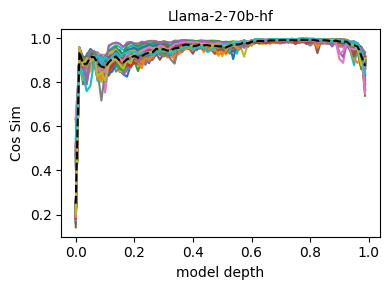

In [88]:
last_token_sim = torch.tensor(last_token_sim)
num_layers = len(base_model.model.layers)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim.T)
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim.mean(dim=0),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()

In [82]:
# ex = """The woman who died after falling from a bridge over the A21 has been identified as a Sevenoaks mum. Marta Kendle, 37, fell from the Gracious Lane bridge on the morning of February 19. Police were called to the carriageway around 6.10am and the road was promptly closed in both directions. Despite paramedics best efforts, Marta, who was originally from Poland, was pronounced dead at the scene. Kent and Medway Coroners office have confirmed an inquest into her death will open on Wednesday (February 27). Tributes to the mum were left at the scene and on social media. Friend, Jodi Cahill posted on Facebook: "I will certainly remember you. I am sorry we did not see how lost and alone you felt. "Be at peace dear Marta." A floral tribute left at the scene said goodbye to the "beautiful and kind soul". It read: "To a beautiful and kind soul, we are sorry we didn&apos;t see your pain. We will miss you always. "Rest in peace Marta, Love from Lorraine, Colin and family." The inquest will take place at the Archbishop&apos;s Palace in Maidstone and will examine the circumstances surrounding Mrs Kendle&apos;s death. Are you struggling or know someone who is? Watch our video below to find out how the Samaritans could help. Mrs Kendle&apos;s death prompted the setting up of a petition calling for higher railings along the Gracious Lane bridge by Sevenoaks Common - to prevent people falling and to protect drivers from below. By today (February 25) 4,500 people had signed. The same site was the scene of another death in July last year when Southborough woman, Angela Skinner, 54, also died after falling on to the A21."""
# ex = "hello world"
ex = "ABC is a startup based in New York City and Paris"
tokens = tokenizer(ex, return_tensors='pt')
input_ids = tokens.input_ids.cuda()
print(input_ids.shape)
seq_length = input_ids.size(1)
attention_mask = tokens.attention_mask.cuda()

embed_model = base_model.model.embed_tokens
input_embeds = embed_model(input_ids) 

attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask, (1, seq_length),
            input_embeds, 0
            )
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
similarity = []
vectors = []
with torch.no_grad():
    x_old = input_embeds
    for idx, block in enumerate(base_model.model.layers):
        x_new = block(x_old,attention_mask=attention_mask)[0]
        ex_ind = 4
        # similarity.append(cos(x_new,x_old).cpu())
        vectors.append(x_old[:,ex_ind,:])
        similarity.append(cos(x_new[:,ex_ind,:].to(torch.float32),x_old[:,ex_ind,:].to(torch.float32)).cpu())
        x_old = x_new
    x = base_model.model.norm(x_new)
    x = base_model.lm_head(x)
print(x.shape)
similarity = torch.stack(similarity).squeeze()

torch.Size([1, 12])
torch.Size([1, 12, 32000])


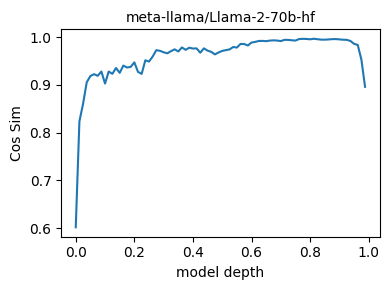

In [83]:
num_layers = len(base_model.model.layers)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(num_layers)/num_layers, similarity)#[:,1:])
# plt.plot(torch.arange(num_layers)/num_layers, similarity[:,1:].mean(dim=1),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"test_{model_name.split('/')[-1]}.png")
plt.show()

In [42]:
similarity[55].item()
# print(base_model)

0.0

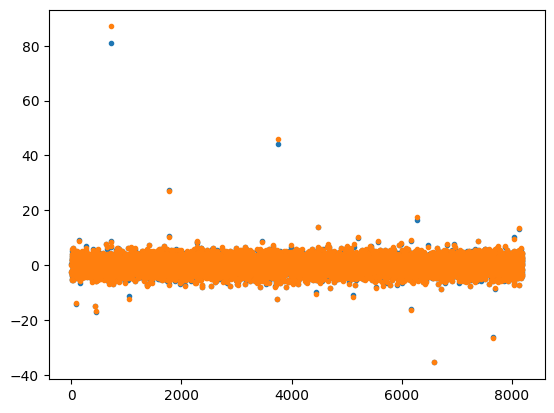

In [48]:
v1 = vectors[55].squeeze().cpu().numpy()
v2 = vectors[56].squeeze().cpu().numpy()
plt.plot(v1,".")
plt.plot(v2,".")
plt.show()


In [72]:
import numpy as np
# np.dot(v1,v2)/ (np.linalg.norm(v1)*np.linalg.norm(v2))
# np.linalg.norm(v1)
# np.argwhere(np.isinf(v2))

np.linalg.norm(v2.astype(np.float32))


259.12784

In [10]:
# ex = "hello world!"
ex = "ABC is a startup based in New York City and Paris"
tokens = tokenizer(ex, return_tensors='pt')
input_ids = tokens.input_ids.cuda()
attention_mask = tokens.attention_mask.cuda()
embed_model = base_model.model.embed_tokens
input_embeds = embed_model(input_ids) 
x = input_ids
seq_length = input_ids.size(1)

attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask, (1, seq_length),
            input_embeds, 0
            )
with torch.no_grad():
    x = input_embeds
    # base_model.model.layers = torch.nn.ModuleList([block for idx, block in enumerate(base_model.base_model.layers)])
    # x = base_model.model(inputs_embeds=x)[0]
    for idx, block in enumerate(base_model.model.layers):
        # print(block(x)[0].shape)
        # position_ids = torch.arange(0, seq_length , dtype=torch.long, device="cuda")
        # position_ids = position_ids.unsqueeze(0)
        # attention_mask = _prepare_4d_causal_attention_mask(attention_mask, (1, seq_length), input_embeds, 0)
        x = block(x,attention_mask=attention_mask)[0]#, position_ids = position_ids)[0]
        # print(len(x))
    x = base_model.model.norm(x)
    x = base_model.lm_head(x)
print(x.shape)

torch.Size([1, 12, 32000])


In [5]:
with torch.no_grad():
    y = base_model(input_ids).logits
# print(torch.allclose(x,y))

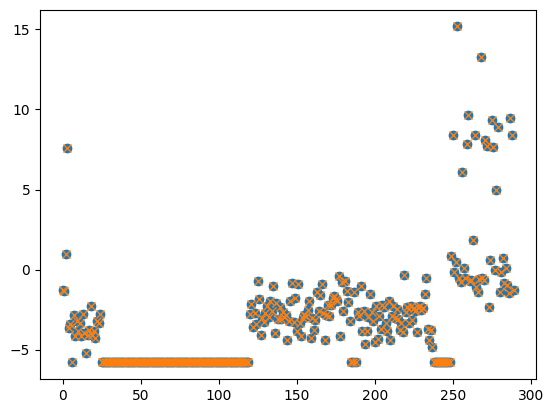

In [8]:
plt.plot(x[0,5,10:300].cpu(),"o")
plt.plot(y[0,5,10:300].cpu(),"x")
plt.show()

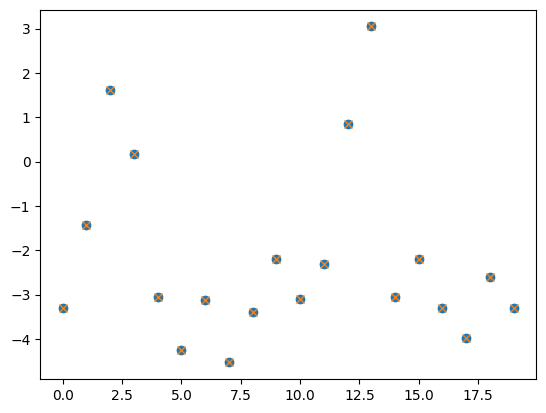

In [43]:
plt.plot(x1[0,0,:20].cpu(),"o")
plt.plot(x2[0,0,:20].cpu(),"x")


In [28]:
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
)

SyntaxError: invalid syntax (308382997.py, line 2)